In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



**Code based on**

- https://www.kaggle.com/todnewman/keras-neural-net-for-champs
- https://www.kaggle.com/criskiev/distance-is-all-you-need-lb-1-481

In [0]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import gc
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from keras.layers import Dense, Input, Activation, Flatten
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K



Using TensorFlow backend.


In [0]:
path = "/content/drive/My Drive/work/Predicing_Molecular_Properties/Data/tmp"
# use atomic numbers to recode atomic names

In [0]:
!ls '{path}'

1_1JHC	  2_2JHH  5_2JHC  8_3JHN     sub.csv	     test_NN_04.ipynb
1_1JHC_0  3_1JHN  6_3JHH  final.csv  sub_tmp_04.csv  test_NN_58.ipynb
1_1JHC_1  4_2JHN  7_3JHC  NN.ipynb   sub_tmp.csv     wrt


In [0]:
def create_nn_model(input_shape):
    inp = Input(shape=(input_shape,))
    x = Dense(2048, activation="relu")(inp)
    x = BatchNormalization()(x)
    #x = Dropout(0.4)(x)
    x = Dense(1024, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    out = Dense(1, activation="linear")(x)  
    model = Model(inputs=inp, outputs=[out])
    return model

In [0]:
def plot_history(history, label):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

In [0]:
# Set up GPU preferences
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config) 
K.set_session(sess)

In [0]:
mol_types = {
             0: '1_1JHC_0',
             1: '1_1JHC_1',
             2: '2_2JHH',
             3: '3_1JHN',
             4: '4_2JHN',
             5: '5_2JHC',
             6: '6_3JHH',
             7: '7_3JHC',
             8: '8_3JHN', 
            }

In [0]:
sub = pd.read_csv(f'{path}/sub_tmp.csv', low_memory=False)

EPOCHS:  1000
BATCH SIZE:  512 

Training 7_3JHC out of {7: '7_3JHC', 8: '8_3JHN'} 




W0824 16:11:19.390657 140598692980608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0824 16:11:19.392358 140598692980608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0824 16:11:19.395854 140598692980608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0824 16:11:19.480382 140598692980608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.




>> Train_input
(1359341, 119)
>> Test_input
(811999, 119)


W0824 16:11:19.700680 140598692980608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0824 16:11:20.139883 140598692980608 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.




Epoch 00195: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00245: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00281: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00313: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00333: early stopping


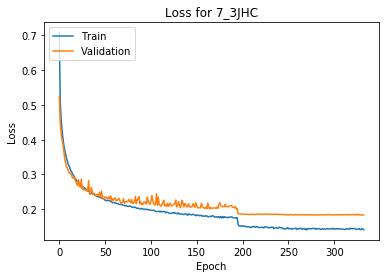

-1.6990124
save tmp_sub
Training 8_3JHN out of {7: '7_3JHC', 8: '8_3JHN'} 



>> Train_input
(149773, 67)
>> Test_input
(90616, 67)

Epoch 00257: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00342: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00409: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00429: early stopping


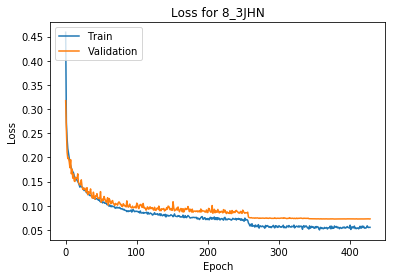

-2.6220498
save tmp_sub


In [0]:
from datetime import datetime

cv_score = []
cv_score_total = 0
epoch_n = 1000
verbose = 0
batch_size = 512

# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain = True

start_time = datetime.now()


print("EPOCHS: ", epoch_n)
print("BATCH SIZE: ", batch_size, '\n')


# Loop through each molecule type
for idx in mol_types:
    mol_type = mol_types[idx]
    model_name_wrt = (f'{path}/wrt/molecule_model_%s.hdf5' % mol_type)

#     model_name_wrt = ('/kaggle/working/molecule_model_%s.hdf5' % mol_type)

    print('Training %s' % mol_type, 'out of', mol_types, '\n\n')
    

    df_train_ = pd.read_csv(f'{path}/{mol_type}/x_train.csv', index_col=0, low_memory=False)
    df_test_ = pd.read_csv(f'{path}/{mol_type}/x_test.csv', index_col=0, low_memory=False)
    y_train = pd.read_pickle(f'{path}/{mol_type}/y_train.csv')
    test_prediction = np.zeros(len(df_test_))

    df_train_  = df_train_.fillna(0)
    df_test_  = df_test_.fillna(0)

    # Standard Scaler from sklearn does seem to work better here than other Scalers
    input_data = StandardScaler().fit_transform(
        pd.concat([df_train_, df_test_]))

    
    # input_data=StandardScaler().fit_transform(df_train_.loc[:,input_features])
    target_data = y_train.values

    # Simple split to provide us a validation set to do our CV checks with
    train_index, cv_index = train_test_split(
        np.arange(len(df_train_)), random_state=111, test_size=0.1)
    # Split all our input and targets by train and cv indexes
    train_target = target_data[train_index]
    cv_target = target_data[cv_index]
    train_input = input_data[train_index]
#     train_input = np.reshape(train_input, (-1, train_input.shape[1], 1))
    cv_input = input_data[cv_index]
#     cv_input = np.reshape(cv_input, (-1, cv_input.shape[1], 1))
    test_input = input_data[len(df_train_):, :]
#     test_input = np.reshape(test_input, (-1, test_input.shape[1], 1))

    print('\n>> Train_input')
    print(train_input.shape)
    print('>> Test_input')
    print(test_input.shape)

#     break

    # Build the Neural Net
    nn_model = create_nn_model(train_input.shape[1])

    # If retrain==False, then we load a previous saved model as a starting point.
    if not retrain:
        nn_model = load_model(model_name_rd)

    nn_model.compile(loss='mae', optimizer=Adam())  # , metrics=[auc])

    # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001,
                                 patience=50, verbose=1, mode='auto', restore_best_weights=True)
    # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
    rlr = callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=30, min_lr=1e-6, mode='auto', verbose=1)
    # Save the best value of the model for future use
    sv_mod = callbacks.ModelCheckpoint(
        model_name_wrt, monitor='val_loss', save_best_only=True, period=1)
    history = nn_model.fit(train_input, [train_target],
                           validation_data=(cv_input, [cv_target]),
                           callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)

    cv_predict = nn_model.predict(cv_input)
    plot_history(history, mol_type)
    accuracy = np.mean(np.abs(cv_target-cv_predict[:, 0]))
    print(np.log(accuracy))
    cv_score.append(np.log(accuracy))
    cv_score_total += np.log(accuracy)

    # Predict on the test data set using our trained model
    test_predict = nn_model.predict(test_input)

    # for each molecule type we'll grab the predicted values
    sub.loc[sub.typei == idx, 'scalar_coupling_constant'] = test_predict
    print('save tmp_sub')
    sub.to_csv(f'{path}/sub_tmp.csv', index=False)
    K.clear_session()
    gc.collect()

cv_score_total /= len(mol_types)

In [0]:
print ('Total training time: ', datetime.now() - start_time)

i=0
for idx in mol_types: 
    mol_type = mol_types[idx]
    print(mol_type,": cv score is ",cv_score[i])
    i+=1
print("total cv score is",cv_score_total)

Total training time:  3:32:20.350573
1_1JHC_0 : cv score is  -0.8610439
1_1JHC_1 : cv score is  -1.8092055
2_2JHH : cv score is  -2.5978758
3_1JHN : cv score is  -1.5214456
4_2JHN : cv score is  -2.3654904
total cv score is -1.8310122609138488


In [0]:
final = sub.drop('typei', axis=1)
final.to_csv(f'{path}/final.csv', index=False)